# Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pysheds.grid import Grid
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

# Read raw DEM

In [2]:
grid = Grid.from_raster("../data/roi_10m", data_name="dem")

In [3]:
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

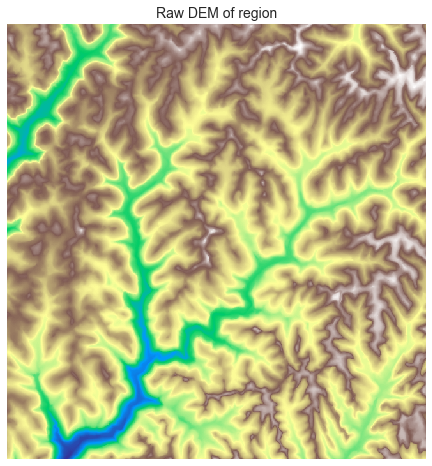

In [4]:
# Plot raw DEM
fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(grid.view("dem"), zorder=1, cmap="terrain")
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.title("Raw DEM of region", size=14)

# Detect and fill depressions in DEM

Pits consist of regions (possibly groups of cells) for which every surrounding cell is at a higher elevation.

In [5]:
# Detect pits
depressions = grid.detect_nondraining_flats("dem")

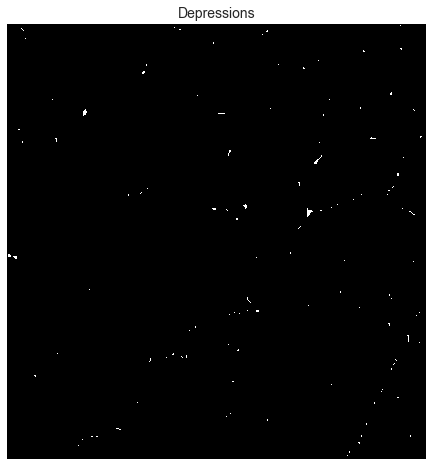

In [6]:
# Plot pits
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(depressions, cmap="cubehelix", zorder=1)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.title("Depressions", size=14)

In [7]:
# Fill depressions
grid.fill_depressions(data="dem", out_name="flooded_dem")

# Detect and correct flats in DEM

Flats consist of cells at which every surrounding cell is at the same elevation or higher.

In [8]:
# Detect flats
flats = grid.detect_flats("flooded_dem")

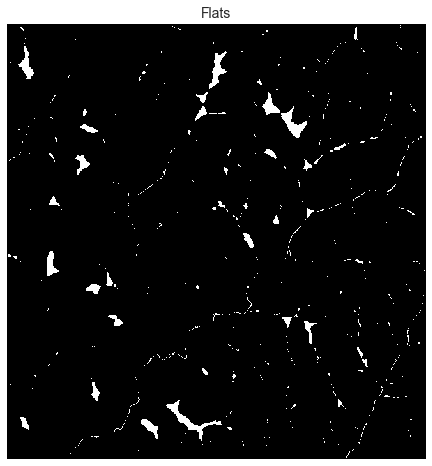

In [9]:
# Plot flats
fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(flats, cmap="cubehelix", zorder=1)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.title("Flats", size=14)

In [10]:
# Attempt to correct flats
grid.resolve_flats(data="flooded_dem", out_name="inflated_dem")

In [11]:
# Detect remaining flats
flats = grid.detect_flats("inflated_dem")

In [12]:
# Compute flow direction based on corrected DEM
grid.flowdir(data="inflated_dem", out_name="dir", dirmap=dirmap)
# Compute flow accumulation based on computed flow direction
grid.accumulation(data="dir", out_name="acc", dirmap=dirmap)

In [13]:
# Delineate catchment at point of high accumulation
y, x = np.unravel_index(np.argsort(grid.acc.ravel())[-2], grid.acc.shape)
grid.catchment(x, y, data="dir", out_name="catch", dirmap=dirmap, xytype="index")

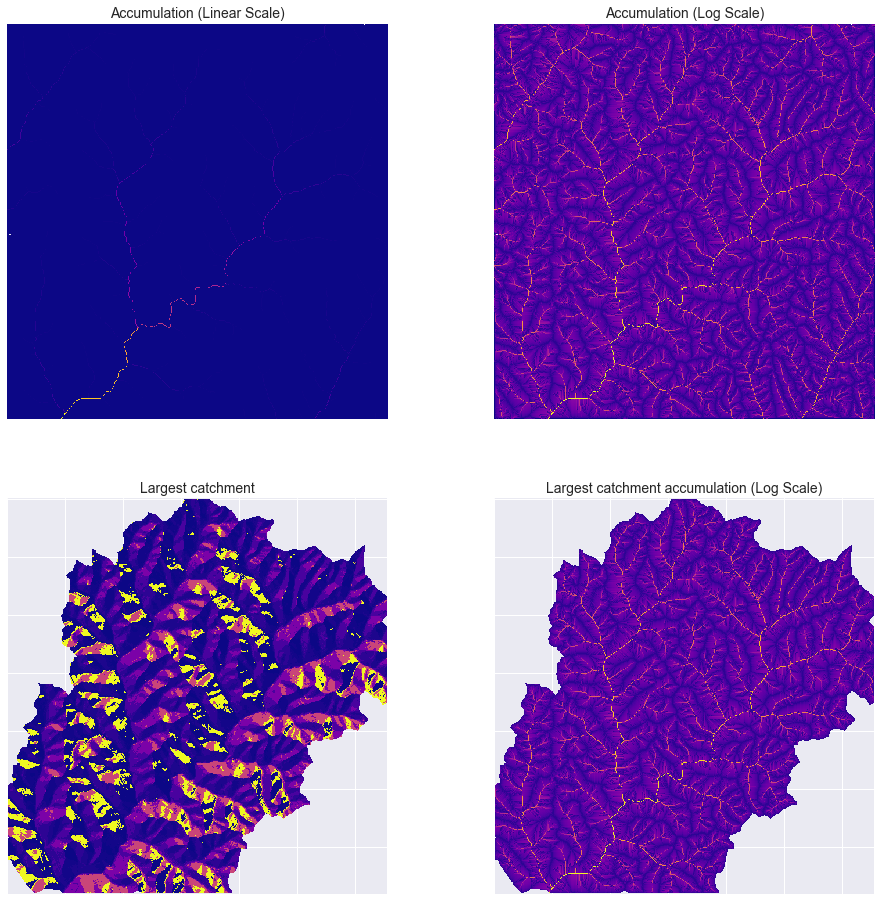

In [14]:
# Plot accumulation and catchment
fig, ax = plt.subplots(2, 2, figsize=(16, 16))
ax[0, 0].imshow(np.where(~flats, grid.view("acc") + 1, np.nan), zorder=1, cmap="plasma")
ax[0, 1].imshow(
    np.where(~flats, grid.view("acc") + 1, np.nan),
    zorder=1,
    cmap="plasma",
    norm=colors.LogNorm(vmin=1, vmax=grid.acc.max()),
)
ax[1, 0].imshow(np.where(grid.catch, grid.catch, np.nan), zorder=1, cmap="plasma")
ax[1, 1].imshow(
    np.where(grid.catch, grid.view("acc") + 1, np.nan),
    zorder=1,
    cmap="plasma",
    norm=colors.LogNorm(vmin=1, vmax=grid.acc.max()),
)

ax[0, 0].set_title("Accumulation (Linear Scale)", size=14)
ax[0, 1].set_title("Accumulation (Log Scale)", size=14)
ax[1, 0].set_title("Largest catchment", size=14)
ax[1, 1].set_title("Largest catchment accumulation (Log Scale)", size=14)

for i in range(ax.size):
    ax.flat[i].set_yticklabels([])
    ax.flat[i].set_xticklabels([])